In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
def gen_pcorr(df, method = "pearson", sig = 0.01):
    # Correlation type:
    # 'pearson': Pearson r product-moment correlation
    # 'spearman': Spearman ρ rank-order correlation
    # 'kendall': Kendall’s τB correlation (for ordinal data)
    # 'bicor': Biweight midcorrelation (robust)
    # 'percbend': Percentage bend correlation (robust)
    # 'shepherd': Shepherd’s pi correlation (robust)
    # 'skipped': Skipped correlation (robust)
    pcs_dct = {}
    for x in df.keys():
        pcs_dct[x]={}
        for y in df.keys():
            # control variables
            # select variables that are not x or y
            other_vars = [z for z in df.keys() if z != y and z != x ]
            if x == y:
                # No need to calculate if the variable is itself
                pcs_dct[x][y] = 1
            else:
                pcs_dct[x][y] = df.partial_corr(x=x,y=y, covar=other_vars,
                                      method=method).round(3)

    return pcs_dct

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df
    

### This code will automatically download data

In [2]:
# Create PDF that will hold visualizations
today = datetime.datetime.today()
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05
# Choose data from FRED
# Keys will be used to name variable. Key points to FRED code
data_codes  = {"Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "CURRCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Excess Reserves (%)": "IOER"}

data_dict = {}
freq = "Q"
start = datetime.datetime(1975, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end = today

# Select start and end dates
# end = datetime.datetime.today()
# Check if data has been gathered.
# If data needs to be gathered again, clear variables or restart kernel
if "data_gathered" not in locals():
    df = gather_data(data_codes, start, 
          end = end, freq = freq)
    ticker = "^GSPC"
    freq = "Q"
    df.fillna(0, inplace=True)
    df["S&P"]= web.DataReader(ticker, start = start, end = end, 
                        data_source = "yahoo").resample(freq).mean()["Close"]
    df["S&P Growth Rate (%)"] = df["S&P"].pct_change(4)
    df["Base: Currency in Circulation ($ Mil)"] = df["Base: Currency in Circulation ($ Bil)"].mul(1000)
    df["Base: Currency not in Circulation ($ Mil)"] = df["Base: Total ($ Mil)"].sub(df["Base: Currency in Circulation ($ Mil)"])
    df["Currency in Circulation Growth Rate (%)"] = df["Base: Currency in Circulation ($ Mil)"].pct_change(4) * 100
    df["% Currency not in Circulation"] = df["Base: Currency not in Circulation ($ Mil)"].div(df["Base: Total ($ Mil)"]) * 100
    df["Inflation (GDPDEF)"] = df["GDP Deflator"].pct_change(4) * 100
    df["Inflation (CPI)"] = df["CPI"].pct_change(4) * 100
    df["Nominal GDP ($ Mil)"] = df["Nominal GDP ($ Bil)"].mul(1000)
    df["Nominal GDP Growth Rate (%)"] = df["Nominal GDP ($ Bil)"].pct_change(4) * 100


C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### These are the variables for which we will generate partial correlations and which we shall plot.

In [3]:
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             "% Currency not in Circulation",
             "Inflation (CPI)",
             "S&P Growth Rate (%)",
             "Nominal GDP Growth Rate (%)",
             "1 Year Treasury Rate (%)"]
pcs_dct = gen_pcorr(df[plot_vars].dropna()[:-1], method = "pearson", sig = .01)

After running generating the output using gen_pcorr, we create one dictionary for holding the p-values and another for holding the partial correlation values

In [4]:
def save_corr_and_p_vals(pcs_dct):
    corr_dct ={}
    p_vals_dct = {}
    for key in pcs_dct:
        corr_dct[key] ={}
        p_vals_dct[key] = {}
        for key2 in pcs_dct[key]:
            if type(pcs_dct[key][key2]) != int:
                corr_dct[key][key2] =  pcs_dct[key][key2]["r"][0]
                p_vals_dct[key][key2] = pcs_dct[key][key2]["p-val"][0]
            else:
                corr_dct[key][key2] =  np.nan
                p_vals_dct[key][key2] = 1
    return corr_dct, p_vals_dct
corr_dct, p_vals_dct = save_corr_and_p_vals(pcs_dct)
pd.DataFrame(p_vals_dct).sort_index(axis=0, ascending=True).sort_index(axis=1, ascending = True)

,% Currency not in Circulation,1 Year Treasury Rate (%),Currency in Circulation Growth Rate (%),Inflation (CPI),Nominal GDP Growth Rate (%),S&P Growth Rate (%)
% Currency not in Circulation,1.000,0.000,0.000,0.000,0.199,0.047
1 Year Treasury Rate (%),0.000,1.000,0.008,0.000,0.001,0.082
Currency in Circulation Growth Rate (%),0.000,0.008,1.000,0.911,0.664,0.108
Inflation (CPI),0.000,0.000,0.911,1.000,0.000,0.001
Nominal GDP Growth Rate (%),0.199,0.001,0.664,0.000,1.000,0.000
S&P Growth Rate (%),0.047,0.082,0.108,0.001,0.000,1.000


In [5]:
pd.DataFrame(corr_dct).sort_index(axis=0, ascending=True).sort_index(axis=1, ascending = True)

,% Currency not in Circulation,1 Year Treasury Rate (%),Currency in Circulation Growth Rate (%),Inflation (CPI),Nominal GDP Growth Rate (%),S&P Growth Rate (%)
% Currency not in Circulation,NaN,-0.512,0.272,0.261,-0.096,0.148
1 Year Treasury Rate (%),-0.512,NaN,0.196,0.588,0.249,0.130
Currency in Circulation Growth Rate (%),0.272,0.196,NaN,-0.008,0.033,-0.120
Inflation (CPI),0.261,0.588,-0.008,NaN,0.351,-0.243
Nominal GDP Growth Rate (%),-0.096,0.249,0.033,0.351,NaN,0.268
S&P Growth Rate (%),0.148,0.130,-0.120,-0.243,0.268,NaN


### Then we graph the statistically significant partial correlations

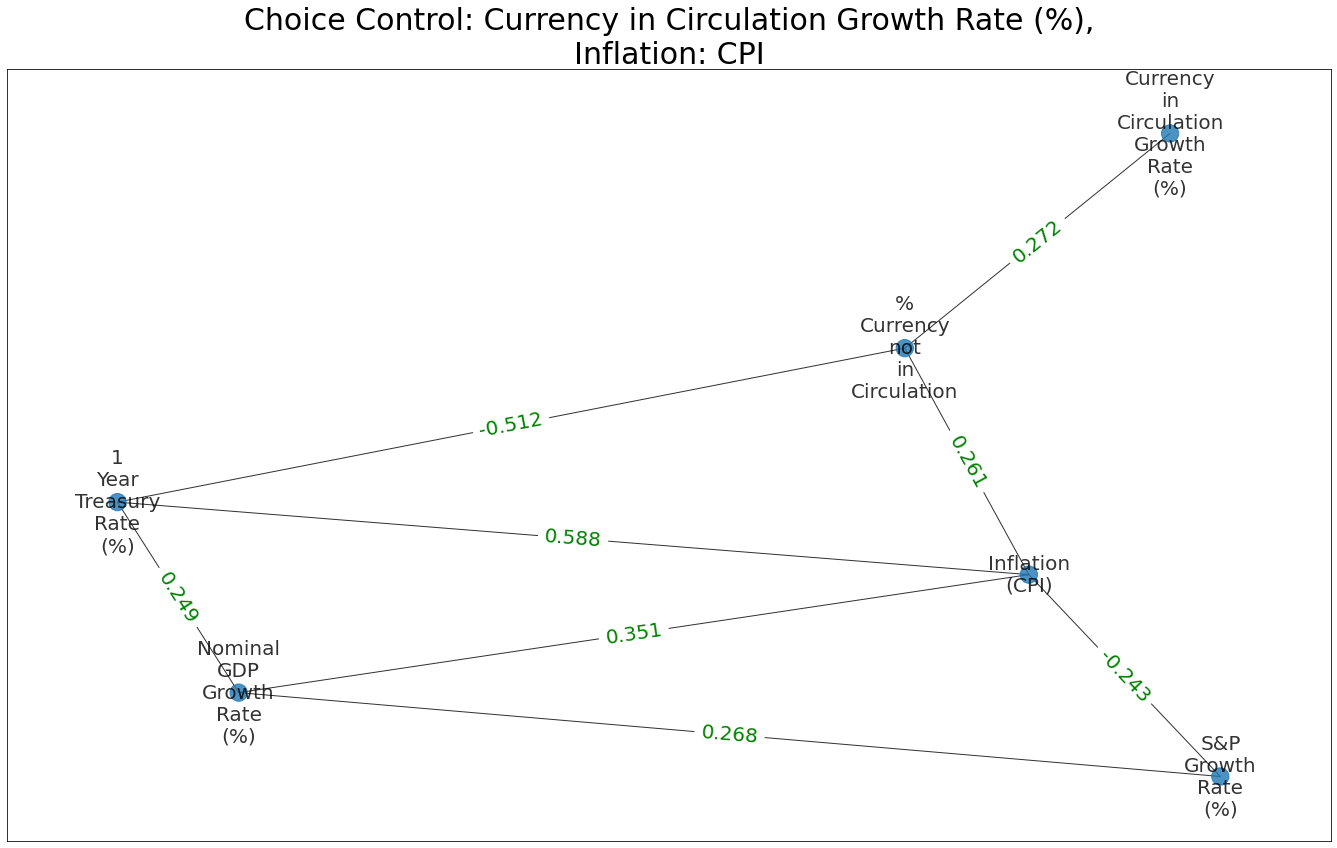

In [6]:
plt.rcParams['axes.ymargin'] = .1
plt.rcParams['axes.xmargin'] = .1
import networkx as nx
def graph_pcorr(p_vals_dct, corr_dct, title = "Macro Partial Correlations", sig = .001):

    # initiate graph
    graph = nx.Graph()
    #make list for edges
    edges = []
    # and a list for correlation values to use  as labels
    edge_labels = {}
    for key in p_vals_dct:
        for key2 in p_vals_dct[key]:
            # don't add edge:
            #   1. keys are identical
            #   2. If p-val > sig
            if key != key2  and p_vals_dct[key][key2] <= sig:
                edge = (key.replace(" ","\n"), key2.replace(" ","\n"))
                alt_edge = (edge[1],edge[0])
                # only append if keys are not already in edges as (key2, key)
                if alt_edge not in edges:
                    edges.append(edge)
                    edge_labels[edge] = str(corr_dct[key][key2])

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    # make all nodes in graph blue ("C0")
    color_map = ["C0" for g in graph]
    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    # automatically space nodes
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = .8,
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
graph_pcorr(p_vals_dct, corr_dct, "Choice Control: Currency in Circulation Growth Rate (%),\nInflation: CPI")

In [7]:
import copy
def map_pcs(df, method = "pearson"):
    def check_naive_corr(pcs_dct):
        def check_remaining_controls(control_vars, p_dct, 
                                     x, y, controls_used):
            c_used = copy.copy(controls_used)
            for c_var in control_vars:
                c_used.append(c_var)
                pcorr = df.partial_corr(x=x,y=y, covar=c_used,
                                      method=method).round(3)
                p_dct[c_var] = {}
                p_dct[c_var]["r"] = pcorr["r"].values[0]
                p_dct[c_var]["p-val"] = pcorr["p-val"].values[0]
                
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, p_dct[c_var], x, y, c_used)
            
        for x in df.keys():
            pcs_dct[x]={}
            for y in df.keys():
                pcs_dct[x][y] = {}
                if x == y:
                # No need to calculate if the variable is itself
                    pcs_dct[x][y]["r"] = 1
                else:
                    
                    pcorr = df.partial_corr(x=x,y=y, covar=None,
                                          method=method).round(3)
                    pcs_dct[x][y]["r"] = pcorr["r"].values[0]
                    pcs_dct[x][y]["p-val"] = pcorr["p-val"].values[0]
                    #other_vars = [z for z in df.keys() if z != y and z != x ]
                ### Check controls to evaluate d-separate / d-connected
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, pcs_dct[x][y], 
                                             x, y, controls_used = [])    

    pcs_dct = {}
    check_naive_corr(pcs_dct)
    return pcs_dct
    
#MV=Py
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             "% Currency not in Circulation",
             "Inflation (CPI)",
             "S&P Growth Rate (%)",
             "Nominal GDP Growth Rate (%)",
             "1 Year Treasury Rate (%)"]

pcs_dct = map_pcs(df[plot_vars].dropna()[:-1], method = "pearson")


{'Currency in Circulation Growth Rate (%)': {'Currency in Circulation Growth Rate (%)': {'r': 1},
  '% Currency not in Circulation': {'r': 0.122,
   'p-val': 0.104,
   'Inflation (CPI)': {'r': 0.188,
    'p-val': 0.011,
    'S&P Growth Rate (%)': {'r': 0.188,
     'p-val': 0.011,
     'Nominal GDP Growth Rate (%)': {'r': 0.204,
      'p-val': 0.006,
      '1 Year Treasury Rate (%)': {'r': 0.272, 'p-val': 0.0}},
     '1 Year Treasury Rate (%)': {'r': 0.272,
      'p-val': 0.0,
      'Nominal GDP Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}}},
    'Nominal GDP Growth Rate (%)': {'r': 0.204,
     'p-val': 0.006,
     'S&P Growth Rate (%)': {'r': 0.204,
      'p-val': 0.006,
      '1 Year Treasury Rate (%)': {'r': 0.272, 'p-val': 0.0}},
     '1 Year Treasury Rate (%)': {'r': 0.272,
      'p-val': 0.0,
      'S&P Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}}},
    '1 Year Treasury Rate (%)': {'r': 0.272,
     'p-val': 0.0,
     'S&P Growth Rate (%)': {'r': 0.272,
      'p-val': 0.0,
      '

In [10]:
pcs_dct["Currency in Circulation Growth Rate (%)"]["% Currency not in Circulation"]

{'r': 0.122,
 'p-val': 0.104,
 'Inflation (CPI)': {'r': 0.188,
  'p-val': 0.011,
  'S&P Growth Rate (%)': {'r': 0.188,
   'p-val': 0.011,
   'Nominal GDP Growth Rate (%)': {'r': 0.204,
    'p-val': 0.006,
    '1 Year Treasury Rate (%)': {'r': 0.272, 'p-val': 0.0}},
   '1 Year Treasury Rate (%)': {'r': 0.272,
    'p-val': 0.0,
    'Nominal GDP Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}}},
  'Nominal GDP Growth Rate (%)': {'r': 0.204,
   'p-val': 0.006,
   'S&P Growth Rate (%)': {'r': 0.204,
    'p-val': 0.006,
    '1 Year Treasury Rate (%)': {'r': 0.272, 'p-val': 0.0}},
   '1 Year Treasury Rate (%)': {'r': 0.272,
    'p-val': 0.0,
    'S&P Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}}},
  '1 Year Treasury Rate (%)': {'r': 0.272,
   'p-val': 0.0,
   'S&P Growth Rate (%)': {'r': 0.272,
    'p-val': 0.0,
    'Nominal GDP Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}},
   'Nominal GDP Growth Rate (%)': {'r': 0.272,
    'p-val': 0.0,
    'S&P Growth Rate (%)': {'r': 0.272, 'p-val': 0.0}}}},

In [ ]:
import copy
def map_pcs(df, method = "pearson"):
    def check_naive_corr(pcs_dct):
        def check_remaining_controls(control_vars, p_dct, 
                                     x, y, controls_used):
            c_used = copy.copy(controls_used)
            for c_var in control_vars:
                c_used.append(c_var)
                pcorr = df.partial_corr(x=x,y=y, covar=c_used,
                                      method=method).round(3)
                p_dct[c_var] = {}
                p_dct[c_var]["r"] = pcorr["r"].values[0]
                p_dct[c_var]["p-val"] = pcorr["p-val"].values[0]
                
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, p_dct[c_var], x, y, c_used)
            
        for x in df.keys():
            pcs_dct[x]={}
            for y in df.keys():
                pcs_dct[x][y] = {}
                if x == y:
                # No need to calculate if the variable is itself
                    pcs_dct[x][y]["r"] = 1
                else:
                    
                    pcorr = df.partial_corr(x=x,y=y, covar=None,
                                          method=method).round(3)
                    pcs_dct[x][y]["r"] = pcorr["r"].values[0]
                    pcs_dct[x][y]["p-val"] = pcorr["p-val"].values[0]
                    #other_vars = [z for z in df.keys() if z != y and z != x ]
                ### Check controls to evaluate d-separate / d-connected
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, pcs_dct[x][y], 
                                             x, y, controls_used = [])    

    pcs_dct = {}
    check_naive_corr(pcs_dct)
    return pcs_dct
    
#MV=Py
plt.rcParams.update({'font.size': 24})
plot_vars = ["Currency in Circulation Growth Rate (%)",
             "% Currency not in Circulation",
             "Inflation (CPI)",
             "S&P Growth Rate (%)",
             "Nominal GDP Growth Rate (%)",
             "1 Year Treasury Rate (%)"]

pcs_dct = map_pcs(df[plot_vars].dropna()[:-1], method = "pearson")
